In [12]:
import matplotlib.pyplot as plt
import numpy as np

import wandb
from wandb_util import first_used_artifact_of_type

In [2]:
api = wandb.Api()

runs = api.runs('romeu/mip-NeRF2D')
runs = [r for r in runs if r.job_type == 'evaluation-render-multiscale']

In [3]:
from tqdm import tqdm
from wandb.apis.public import Run
from dataclasses import dataclass

@dataclass
class RunData:
    run: Run
    enc_type: str
    dataset_name: str
    res: int

runs_data = []

for r in tqdm(runs):
    enc = r.config['encoding_settings']['type']
    res = r.config['res']

    model = first_used_artifact_of_type(r, 'model')
    training_run = model.logged_by()
    dataset_artifact = first_used_artifact_of_type(training_run, 'multiscale-dataset')

    dataset_name, _ = dataset_artifact.name.split(':')

    runs_data.append(RunData(r, enc, dataset_name, res))

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


In [41]:
from collections import defaultdict

ssims_dict = defaultdict(lambda: {})

for run in tqdm(runs_data):
    ssims = run.run.history()['ssim']
    max_ssim = np.max(ssims)

    ssims_dict[run.res][f'{run.enc_type}-{run.dataset_name}'] = max_ssim

print(ssims_dict)

100%|██████████| 20/20 [00:58<00:00,  2.93s/it]

defaultdict(<function <lambda> at 0x7fdba830ca40>, {512: {'IPE-collins-truemulti': 0.5922840237617493, 'PE-collins-truemulti': 0.5438748598098755, 'IPE-collins-single': 0.6809937357902527, 'PE-collins-single': 0.6544468402862549}, 256: {'IPE-collins-truemulti': 0.6388265490531921, 'PE-collins-truemulti': 0.5760606527328491, 'IPE-collins-single': 0.7530437111854553, 'PE-collins-single': 0.7308452129364014}, 128: {'IPE-collins-truemulti': 0.7595310211181641, 'PE-collins-truemulti': 0.6904370188713074, 'IPE-collins-single': 0.845942497253418, 'PE-collins-single': 0.824745774269104}, 64: {'IPE-collins-truemulti': 0.9219789505004883, 'PE-collins-truemulti': 0.8837976455688477, 'IPE-collins-single': 0.924728274345398, 'PE-collins-single': 0.9031389951705933}, 32: {'IPE-collins-truemulti': 0.9860647320747375, 'PE-collins-truemulti': 0.9777839779853821, 'IPE-collins-single': 0.9190403819084167, 'PE-collins-single': 0.8587838411331177}})


([<matplotlib.axis.XTick at 0x7fdba4bbbf90>,
 [Text(512, 0, '512'),
  Text(256, 0, '256'),
  Text(128, 0, '128'),
  Text(64, 0, '64'),
  Text(32, 0, '32')])

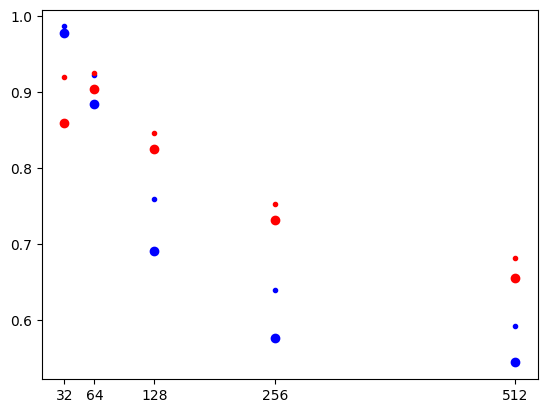

In [65]:
resolutions = np.array(list(ssims_dict.keys()))

pe_ssims_single = np.array([value['PE-collins-single'] for value in ssims_dict.values()])
ipe_ssims_single = np.array([value['IPE-collins-single'] for value in ssims_dict.values()])

pe_ssims_multi = np.array([value['PE-collins-truemulti'] for value in ssims_dict.values()])
ipe_ssims_multi = np.array([value['IPE-collins-truemulti'] for value in ssims_dict.values()])

diffs = ipe_ssims_multi - pe_ssims_multi

plt.scatter(resolutions, pe_ssims_multi, color='blue')
plt.scatter(resolutions, ipe_ssims_multi, color='blue', marker='.')

plt.scatter(resolutions, pe_ssims_single, color='red')
plt.scatter(resolutions, ipe_ssims_single, color='red', marker='.')

plt.xticks(resolutions)